# Interactive Viz

This is our implementation of an interactive vizualization showing differences between the grants amount accorded to university and institute, according to Canton, using P3 database of the SNSF for the grant data.

We use Folium to display the choropleth maps, Google places and GeoName API to link universities with cantons.

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import folium
import os
import json
import geopy
import geocoder
import time
import csv
from IPython.display import IFrame
from geopy.geocoders import Nominatim
#pip install python-google-places


First import the data

In [26]:
dataCrow = pd.read_csv("CrowdstormingDataJuly1st.csv", sep=',')

In [27]:
dataCrow.ix[:8,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0,0


In [28]:
dataCrow.ix[:8,15:]

,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


I take only information about rater1 and rater2 plus the playerShort name.

In [43]:
raterData = dataCrow[['playerShort','rater1','rater2']]
raterData.head()

,playerShort,rater1,rater2
0,lucas-wilchez,0.25,0.50
1,john-utaka,0.75,0.75
2,abdon-prats,NaN,NaN
3,pablo-mari,NaN,NaN
4,ruben-pena,NaN,NaN


Drop the NaN

In [50]:
raterData = raterData.dropna(axis=0,how='any')
raterData.head()

,playerShort,rater1,rater2
0,lucas-wilchez,0.25,0.50
1,john-utaka,0.75,0.75
5,aaron-hughes,0.25,0.00
6,aleksandar-kolarov,0.00,0.25
7,alexander-tettey,1.00,1.00


Substract the two rater value

In [69]:
#raterDataWithDiff['diff']=raterDataWithDiff.rater1-raterDataWithDiff.rater2
raterDataDiff = raterData.copy()
raterDataDiff['raterDiff']=abs(raterDataDiff.rater1-raterDataDiff.rater2)
raterDataDiff.head()


,playerShort,rater1,rater2,raterDiff
0,lucas-wilchez,0.25,0.50,0.25
1,john-utaka,0.75,0.75,0.00
5,aaron-hughes,0.25,0.00,0.25
6,aleksandar-kolarov,0.00,0.25,0.25
7,alexander-tettey,1.00,1.00,0.00


The two raters are evaluated between 0 and 1 with a scal of 0.25. We will plot the histogram of the difference between rater1 and rater2. 

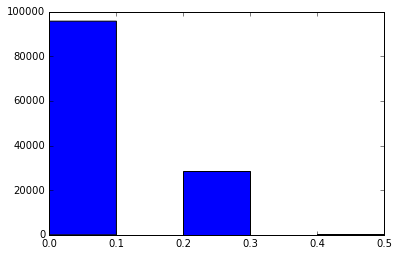

In [90]:
raterDataDiff.raterDiff.hist(bins=5,grid=False)

In [72]:
raterDataDiff.groupby('raterDiff').count()['playerShort']

raterDiff
0.00    95714
0.25    28743
0.50      164
Name: playerShort, dtype: int64

On 124621 player with rater value, we have only 164 inputs in wich the two raters have a difference of 0.5. 

----------------------
----------------------
# Brouillon :
----------------------
----------------------

In [ ]:
#raterData['RateDifference']= raterData.apply(lambda x: x['rater1']- x['rater2'])
#raterDataDiff = raterData
#raterDataDiff['RateDifference']= raterData.apply(lambda x: (x['rater1']- x['rater2']),axis=1)
#raterDataDiff.head()  124 621


In [31]:
#In [325]: dfmi.loc[:,('one','second')]
raterDiffLoc=0
raterDiffLoc = raterData.apply(lambda x:raterData.loc[:,('rater1')]-raterData.loc[:,('rater2')] )

#raterData.loc[:,('rater1')]
#raterDiffLoc=0
raterDiffLoc.head()

,playerShort,rater1,rater2
0,-0.25,-0.25,-0.25
1,0.00,0.00,0.00
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [42]:


#raterData['diff']=raterData.rater1+raterData.rater2
raterDataWithDiff = raterData.copy()
raterDataWithDiff.head()
raterDataWithDiff['diff']=raterDataWithDiff.rater1-raterDataWithDiff.rater2
raterDataWithDiff.head()

,playerShort,rater1,rater2,diff
0,lucas-wilchez,0.25,0.50,-0.25
1,john-utaka,0.75,0.75,0.00
2,abdon-prats,NaN,NaN,NaN
3,pablo-mari,NaN,NaN,NaN
4,ruben-pena,NaN,NaN,NaN


In [34]:
dataGroupByPlayerShort = dataCrow.groupby('playerShort')
len(dataGroupByPlayerShort)

2053

In [35]:
dataGroupedUnique = dataCrow.groupby(['playerShort','player','club','leagueCountry','birthday','position'])
len(dataGroupedUnique)

2053

In [36]:
dataGroupedUniques = dataCrow.groupby(['playerShort','rater2'])
len(dataGroupedUniques)

22992

In [37]:
dataGroupedUniquess = dataCrow.groupby(['playerShort','photoID'])
len(dataGroupedUniquess)
dataGroupedUniquess.size()

playerShort             photoID   
aaron-hughes            3868.jpg      166
aaron-hunt              20136.jpg      99
aaron-lennon            13515.jpg     101
aaron-ramsey            94953.jpg     104
abdelhamid-el-kaoutari  124913.jpg     37
abdou-traore_2          102005.jpg     42
abdoulaye-diallo_2      158172.jpg     20
abdoulaye-keita_2       148612.jpg      2
abdoulwhaid-sissoko     134483.jpg     56
abdul-rahman-baba       212277.jpg     27
abdul-razak             184560.jpg     33
abel-aguilar            22987.jpg     110
abelaziz-barrada        196493.jpg     39
abou-diaby              24657.jpg      65
adam-bodzek             36296.jpg      56
adam-campbell           219208.jpg     17
adam-federici           58477.jpg      81
adam-hlousek            54739.jpg      60
adam-johnson            31123.jpg      92
adam-morgan             189486.jpg     23
adam-pinter             88754.jpg      56
adam-smith_3            150651.jpg     70
adam-szalai             53694.jpg      70

In [38]:
dataGroupedByPhoto = dataCrow.groupby(['photoID'])
dataGroupedByPhoto.size()


#dataCrow.isnull()
#rater 1- rater 2 plot distribution 

photoID
100063.jpg     53
100350.jpg     64
10037.jpg     112
10038.jpg      82
100459.jpg     88
10046.jpg     105
100557.jpg     54
10056.jpg      74
10060.jpg      90
10071.jpg     122
10072.jpg     105
10075.jpg      68
10080.jpg      78
10081.jpg      60
10087.jpg      70
100906.jpg     90
100909.jpg     61
10093.jpg      35
10098.jpg     100
10100.jpg     136
10101.jpg     123
10115.jpg     183
10131.jpg     123
10137.jpg     101
10140.jpg      64
101552.jpg     89
10192.jpg      63
102005.jpg     42
10203.jpg      97
102168.jpg     48
             ... 
97358.jpg      81
97366.jpg      60
97515.jpg      91
97519.jpg      97
97527.jpg      86
97537.jpg      84
97655.jpg      75
97789.jpg      31
97803.jpg      71
97814.jpg      90
97820.jpg      75
97857.jpg      87
980.jpg       174
9812.jpg       88
9814.jpg       88
98205.jpg      76
98257.jpg      51
98326.jpg      55
98334.jpg     107
98397.jpg      74
98402.jpg      67
986.jpg       105
9902.jpg       56
9906.jpg       77
99

In [22]:
dataGroupedUniquess.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
